In [6]:
import fix_yahoo_finance as yf  
import pandas as pd 
import numpy as np 
import networkx as nx
import scipy.special 
pd.core.common.is_list_like = pd.api.types.is_list_like 
import pandas_datareader as pdr 
from matplotlib import pyplot as plt
from datetime import date, datetime
import math
import random

# from plotly.offline import iplot
# import plotly.graph_objs as go
# yf.pdr_override() 

##### Выкачиваем необходимые акции

In [0]:
# stocks_trend = ['AAL', 'ABBV', 'ACB', 'ALT', 'BIOC', 'BTC-USD', 'CCL', 'COST', 'DAL', 'GE', 
#                 'JNJ', 'JPM', 'KHC', 'KO', 'LMT', 'LUV', 'NVDA', 'SBUX', 'T', 'TEAM', 'TELL', 
#                 'TWTR', 'VOO', 'VZ', 'WFC', 'WMT', 'WORK', 'XOM',' ^TNX']

# stocks = ['AC','AI','AIR','MT','ATO'] 
# start = datetime.datetime(2019, 1, 1) 
# end = datetime.datetime(2020, 1, 1) 
# data = yf.download(stocks, start=start, end=end) 

In [3]:
stocks_article = ['A', 'AA', 'AAP', 'AAPL', 'AAWW', 'ACCO', 'ABG', 'ACWI', 'ADX']
start = datetime(2010, 11, 1) 
end = datetime(2011, 11, 1) 
data = yf.download(stocks_article, start=start, end=end) 

[*********************100%***********************]  9 of 9 downloaded


##### Проверяем и формируем данные

In [4]:
print(data.shape)
data.head()

(253, 54)


Open                        ...  Volume                
                    A         AA        AAP  ...    ACCO    ACWI     ADX
Date                                         ...                        
2010-11-01  24.992847  31.695570  65.290001  ...  456300  176600  254900
2010-11-02  25.021460  31.599449  65.110001  ...  223500  266900  130800
2010-11-03  25.164520  31.695570  64.570000  ...  238400  241300   70500
2010-11-04  25.393419  32.104080  65.620003  ...  298300  880200  221300
2010-11-05  25.729614  32.849010  65.989998  ...  323100  286300  102300

[5 rows x 54 columns]

In [5]:
data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis='columns', inplace=True)
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3936: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



Close                        ...                        
                    A         AA        AAP  ...  ACCO       ACWI    ADX
Date                                         ...                        
2010-11-01  24.856939  31.359150  64.760002  ...  6.07  44.889999  10.27
2010-11-02  25.078684  31.815720  64.570000  ...  6.12  45.320000  10.33
2010-11-03  25.114449  31.575420  64.940002  ...  6.10  45.570000  10.36
2010-11-04  25.743919  32.680801  65.809998  ...  6.19  46.599998  10.52
2010-11-05  26.022890  33.641998  65.629997  ...  6.54  46.509998  10.59

[5 rows x 9 columns]

##### Функция возвращает список доходностей для одной акции, принимает список цен одной акции

In [0]:
def get_returns(prices):
  returns = []
  for day in range(len(prices)-1):
    returns.append(np.log(prices[day+1]/prices[day]))
    
  return returns

##### Функция возвращает сгенерированные случайные величины, принимает матрицу корреляций и необходимое количесвто наблюдений  

In [0]:
def get_norm_seq(matrix, N):
  return np.random.multivariate_normal(mean=np.zeros(len(matrix[0])), cov=matrix, size=N).T

##### Функция возвращает индикаторы, принимает доходности одной акции

In [0]:
def get_indicators(returns):
  inds = []
  for ret in returns:
    if (ret > 0):
      inds.append(1)
    else:
      inds.append(0)
  return inds

##### Функция возвращает матрицу индикаторов доходностей, принимает матрицу доходностей

In [0]:
def get_inds_matrix(returns):
  ret_inds = []
  for stock in returns:
    ret_inds.append(get_indicators(stock))
  return ret_inds

##### Функция возвращает знаковый коэффициент двух акций 

In [0]:
def get_sign_coef(stock_1, stock_2):
  count = 0
  for t in range(len(stock_1)):
    if (stock_1[t] == stock_2[t]):
      count += 1
  return count 

##### Функция возвращает матрицу знаковых коэффициентов, принимает матрицу индикаторов

In [0]:
def get_coef_matrix(ret_inds):
  sign_coef_matrix = []
  for i in range(len(ret_inds)):
    sign_coef_matrix.append([])
    for j in range(len(ret_inds)):
      sign_coef_matrix[i].append(get_sign_coef(ret_inds[i], ret_inds[j]))
  return sign_coef_matrix


##### Функции подсчета статистик для гипотезы для трех акций и гипотезы для четырех акций, принимают матрицу индикаторов и индексы самих сравниваемых акций

In [0]:
def stat_T2(ret_inds, i, j, k):
  sum = 0
  for t in range(len(ret_inds[0])):
    sum += ret_inds[i][t] * ret_inds[j][t] * (1 - ret_inds[k][t]) + (1 - ret_inds[i][t]) * (1 - ret_inds[j][t]) * ret_inds[k][t]
  return sum

def stat_T3(ret_inds, i, j, k):
  sum = 0
  for t in range(len(ret_inds[0])):
    sum += ret_inds[i][t] * (1 - ret_inds[j][t]) * ret_inds[k][t] + (1 - ret_inds[i][t]) * ret_inds[j][t] * (1 - ret_inds[k][t])
  return sum


Проверка

In [13]:
corr = [[1, 0, 0.2], \
        [0, 1, 0], \
        [0.2, 0, 1]]
new_rets = get_norm_seq(corr, 5)
new_inds = get_inds_matrix(new_rets)
new_inds

[[0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [1, 1, 0, 0, 1]]

In [14]:
print('Кол-во дней, когда i = j != k : ',stat_T2(new_inds, 0, 1, 2))
print('Кол-во дней, когда i = k != j : ',stat_T3(new_inds, 0, 1, 2))

Кол-во дней, когда i = j != k :  0
Кол-во дней, когда i = k != j :  2


Верно

In [0]:
def stat_R2(ret_inds, i, j, k, l):
  sum = 0
  for t in range(len(ret_inds[0])):
    if ret_inds[i][t] == ret_inds[j][t] and ret_inds[k][t] != ret_inds[l][t]:
      sum += 1
  return sum


def stat_R3(ret_inds, i, j, k, l):
  sum = 0
  for t in range(len(ret_inds[0])):
    if ret_inds[i][t] != ret_inds[j][t] and ret_inds[k][t] == ret_inds[l][t]:
      sum += 1
  return sum

Проверка

In [16]:
corr = [[1, 0, 0.3, 0.2], \
        [0, 1, 0, 0.2], \
        [0.3, 0, 1, 0], \
        [0.2, 0.2, 0, 1]]
new_rets = get_norm_seq(corr, 5)
new_inds = get_inds_matrix(new_rets)
new_inds

[[1, 0, 0, 0, 1], [1, 0, 1, 0, 0], [1, 0, 0, 1, 1], [0, 1, 0, 0, 1]]

In [17]:
print('Кол-во дней, когда i = j и k != l : ',stat_R2(new_inds, 0, 1, 2, 3))
print('Кол-во дней, когда i != j и k = l : ',stat_R3(new_inds, 0, 1, 2, 3))

Кол-во дней, когда i = j и k != l :  3
Кол-во дней, когда i != j и k = l :  2


Верно

##### Функция подсчета порога c для теста 

Вопрос:    

Допустим, у нас акция i сильно коррелирует с k, а акция j сильно коррелирует с l (это эль), поэтому если знак i совпадает со знаком j в день t, то и знак k с большой вероятностью совпадет со знаком l в день t. И наоборот, если i не совпадет с j в день t, то и k не совпадет с l в день t с большой вероятностью. То есть таких случаев из выборки будет большинство.        

Допустим, наблюдений немного и случаев, что (i = j, a k != l) или (i != j, a k = l) выпало всего 3 (допустим). А alpha мы взяли 0.1.     

То есть по сути, мы получаем число $k = k_2 + k_3 = 3$,  $alpha = 0.1$, тогда нет такой нижней границы $c$, чтобы выполнилось неравенство $􏰋\sum_{i=c}^k С_k^i * (1/2)^k \leq  alpha$ 


Или более вероятный вариант:    

Гипотеза $H_{ijk}$ о трех акция. Если j и k будут сильно коррелировать и изменяться в одном направлении, то дней, когда их знаки не совпадут, будет очень мало, а это и есть $k = k_2 + k_3$ будет мало. Даже если выборка большая. 


Вопрос:  

Если у нас большая выборка, которую мы нагенерировали для сравнения, например $n = 10000$. То если у нас выпадет $k = k_2 + k_3 = 1100$ (например) или больше, то биномиальный коэффициент (например, 500 из 1100) = inf. 

In [0]:
def get_treshold_c1(alpha, k):
  c = 0 

  while(1):
    summ = 0
    for i in range(c, k+1):
      summ += scipy.special.binom(k, i) 
    summ *= 1/2**k
    # print('c = {}, summ = {}'.format(c, summ))
    
    if summ <= alpha:
      break
    else:
      c += 1

  # return c
  return c


In [0]:
def get_treshold_c2(alpha, k):
  c = k 

  while(1):
    summ = 0
    for i in range(0, c):
      summ += scipy.special.binom(k, i) 
    summ *= 1/2**k
    # print('c = {} summ = {}'.format(c, summ))
    
    if summ <= alpha:
      break
    else:
      c -= 1

  # return c
  return c

Проверка

In [20]:
get_treshold_c1(0.1, 3)

4

In [21]:
get_treshold_c2(0.1, 3)

0

Вот этот случай, описанный выше

In [22]:
get_treshold_c1(0.3, 7)

5

In [23]:
get_treshold_c2(0.3, 7)

3

In [24]:
get_treshold_c1(0.3, 8)

6

In [25]:
get_treshold_c2(0.3, 8)

3

##### Функция теста для трех акций, ret_inds - индикаторы доходностей

In [0]:
def test_ijk(i, j, k, ret_inds, alpha):
  k2 = stat_T2(ret_inds, i, j, k)
  k3 = stat_T3(ret_inds, i, j, k)
  k = k2 + k3
  c1 = get_treshold_c1(alpha, k)
  if k2 == c1:
    # print('test_ijk, random')
    return random.randint(0,1)
  return k2 > c1

In [0]:
def complex_rand_test_ijk(i, j, k, ret_inds, alpha):
  k2 = stat_T2(ret_inds, i, j, k)
  k3 = stat_T3(ret_inds, i, j, k)
  k = k2 + k3
  c1 = get_treshold_c1(alpha, k)
  c2 = get_treshold_c2(alpha, k)

  if k2 > c1:
    return 1
  if k2 < c2:
    return 0
  return random.randint(0,1)


In [0]:
def complex_max_test_ijk(i, j, k, ret_inds, alpha):
  k2 = stat_T2(ret_inds, i, j, k)
  k3 = stat_T3(ret_inds, i, j, k)
  k = k2 + k3
  c1 = get_treshold_c1(alpha, k)
  c2 = get_treshold_c2(alpha, k)

  if k2 > c1:
    return 1
  if k2 < c2:
    return 0
  if k2 == k3:
    return random.randint(0,1)
  else:
    return k2 > k3 


In [29]:
# k = k2 + k3
c = get_treshold_c1(0.6, 100)
k2 = 50
print(c)
if k2 == c:
  print('hey')
else:
  print('fg')

50
hey


##### Функция теста для четырех акций

In [0]:
def test_ijkl(i, j, k, l, ret_inds, alpha):
  k2 = stat_R2(ret_inds, i, j, k, l)
  k3 = stat_R3(ret_inds, i, j, k, l)
  k = k2 + k3
  c = get_treshold_c1(alpha, k)
  if k2 == c:
    # print('test_ijkl, random')
    return random.randint(0,1)
  return k2 > c

In [0]:
def complex_rand_test_ijkl(i, j, k, l, ret_inds, alpha):
  k2 = stat_R2(ret_inds, i, j, k, l)
  k3 = stat_R3(ret_inds, i, j, k, l)
  k = k2 + k3
  c1 = get_treshold_c1(alpha, k)
  c2 = get_treshold_c2(alpha, k)

  if k2 > c1:
    return 1
  if k2 < c2:
    return 0
  return random.randint(0,1)

In [0]:
def complex_max_test_ijkl(i, j, k, l, ret_inds, alpha):
  k2 = stat_T2(ret_inds, i, j, k)
  k3 = stat_T3(ret_inds, i, j, k)
  k = k2 + k3
  c1 = get_treshold_c1(alpha, k)
  c2 = get_treshold_c2(alpha, k)

  if k2 > c1:
    return 1
  if k2 < c2:
    return 0
  if k2 == k3:
    return random.randint(0,1)
  else:
    return k2 > k3 


##### Функция возвращает MST (алгоритм Краскала), принимает матрицу корреляций и лист акций

In [0]:
def create_Kruskal_MST(cor, stocks):
  dict_edges = []
  for i in range(len(stocks)):
    for j in range(i+1, len(stocks)):
      dict_edges.append((cor[i][j], stocks[i], stocks[j]))
  dict_edges.sort(key=lambda i: i[0], reverse=True)
  
  # print(dict_edges)

  G = nx.Graph()
  G.add_edge(dict_edges[0][1], dict_edges[0][2])

  for edge in dict_edges:
    if (edge[2] not in G.nodes()) or (edge[2] in G.nodes() and edge[1] not in nx.node_connected_component(G, edge[2])):
      # print(i[1], ' ', i[2])
      G.add_edge(edge[1], edge[2], weight=edge[0])
    if len(list(G.nodes)) == len(stocks) and nx.is_connected(G):
      return G

##### Функции алгоритма Прима для матриц корреляций и для гипотез 

In [0]:
def create_Prima_MST(coef_matrix, stocks):
  G = nx.Graph()
  G.add_node(stocks[0])
  vert_i = 0
  vert_j = 0
  
  while len(G.nodes) < len(stocks):
    max_ij = []
    for stock_i in G.nodes:
      vert_i = stocks.index(stock_i)
      vert_j = vert_i
      for j in range(len(stocks)):
        if stocks[j] not in G.nodes and stocks[j] != stock_i:
          vert_j = j
          for k in range(j+1, len(stocks)):
            if stocks[k] not in G.nodes and stocks[k] != stock_i:
              if coef_matrix[vert_i][vert_j] < coef_matrix[vert_i][k]:
                vert_j = k
          break
      if vert_i != vert_j:
        max_ij.append((vert_i, vert_j))

    if len(max_ij) != 0:
      
      vert_i = max_ij[0][0]
      vert_j = max_ij[0][1]

      for itr in range(1, len(max_ij)):
        if coef_matrix[vert_i][vert_j] < coef_matrix[max_ij[itr][0]][max_ij[itr][1]]:
          vert_i = max_ij[itr][0]
          vert_j = max_ij[itr][1]
          
      G.add_edge(stocks[vert_i], stocks[vert_j])
  return G

In [0]:
#params: we can put the parameter kind_of_test as 'simple', 'complex_rand' or 'complex_max'

def create_hypot_MST(ret_inds, stocks, alpha=0.05, kind_of_test='simple'):

  if kind_of_test == 'simple':
    test_3 = test_ijk
    test_4 = test_ijkl
  elif kind_of_test == 'complex_rand':
    test_3 = complex_rand_test_ijk
    test_4 = complex_rand_test_ijkl
  elif kind_of_test == 'complex_max':
    test_3 = complex_max_test_ijk
    test_4 = complex_max_test_ijkl

  G = nx.Graph()
  G.add_node(stocks[0])
  vert_i = 0 
  vert_j = 0
  
  while len(G.nodes) < len(stocks):
    max_ij = []
    for stock_i in G.nodes:
      vert_i = stocks.index(stock_i)
      vert_j = vert_i
      for j in range(len(stocks)):
        if stocks[j] not in G.nodes and stocks[j] != stock_i:
          vert_j = j
          for k in range(j+1, len(stocks)):
            if stocks[k] not in G.nodes and stocks[k] != stock_i:
              if test_3(vert_i, vert_j, k, ret_inds, alpha) != 1:
                vert_j = k
          break
      if vert_i != vert_j:
        max_ij.append((vert_i, vert_j))

    # print('max_ij: ', max_ij)

    if len(max_ij) != 0:

      vert_i = max_ij[0][0]
      vert_j = max_ij[0][1]

      for itr in range(1, len(max_ij)):

        if vert_i == max_ij[itr][0]:                #тупой костыль, потом переделаю
          if test_3(vert_i, vert_j, max_ij[itr][1], ret_inds, alpha) != 1:
                vert_j = max_ij[itr][1]

        elif vert_i == max_ij[itr][1]:
          if test_3(vert_i, vert_j, max_ij[itr][0], ret_inds, alpha) != 1:
                vert_j = max_ij[itr][0]

        elif vert_j == max_ij[itr][0]:
          if test_3(vert_j, vert_i, max_ij[itr][1], ret_inds, alpha) != 1:
                vert_i = max_ij[itr][1]

        elif vert_j == max_ij[itr][1]:
          if test_3(vert_j, vert_i, max_ij[itr][0], ret_inds, alpha) != 1:
                vert_i = max_ij[itr][0]
                
        else:
          if test_4(vert_i, vert_j, max_ij[itr][0], max_ij[itr][1], ret_inds, alpha) != 1:
            vert_i = max_ij[itr][0]
            vert_j = max_ij[itr][1]
      # print('take edge {}-{}'.format(stocks[vert_i], stocks[vert_j]))
      G.add_edge(stocks[vert_i], stocks[vert_j])
  return G


In [36]:
print 

<function print>

##### Функция возвращает процент совпавших MST, принимает истиные MST и матрицу корреляций, кол-во наблюдений для случайных величин, лист акций, кол-во итераций (кол-во раз, сколько надо сгенерировать СВ и сравнить MST)
Еще эта функция сразу проверяет, правильно ли написаны алгоритмы Краскала и  Прима, сравнивания степени MST, построенных по ним. Если степени не совпадают, возвращает -1.

In [0]:
def compare_MSTs(ref_MST, ref_corr, observ_num, stocks, iters=1000):
  counter = 0
  ref_degrees = sorted(ref_MST.degree)

  for itr in range(iters):
    new_rets = get_norm_seq(ref_corr, observ_num)
    new_corr = np.corrcoef(new_rets)

    G1 = create_Kruskal_MST(new_corr, stocks)
    G2 = create_Prima_MST(new_corr, stocks) # for testing both algorithms

    new_degrees = sorted(G1.degree)

    if new_degrees != sorted(G2.degree):
      return -1

    if ref_degrees == new_degrees: 
        counter += 1

  return counter/iters


### Блок проверки тестов 

##### Для гипотезы о трех акциях: $h_{ijk}: \gamma_{ij}^{Sg} \leq \gamma_{ik}^{Sg}$



In [0]:
stcks= ['i', 'j', 'k']
corr = [[1, 0, 0.2], \
        [0, 1, 0], \
        [0.2, 0, 1]]

Проверим, правильно ли генерируются новые СВ по заданной матрице корреляций. Для этого сгенерируем СВ и посчитаем для них матрицу корреляции, она должна быть приближенна к истинной. 

In [39]:
new_rets = get_norm_seq(corr, 100)
new_corr = np.corrcoef(new_rets)
new_corr

array([[ 1.        ,  0.16056888,  0.25568921],
       [ 0.16056888,  1.        , -0.00627328],
       [ 0.25568921, -0.00627328,  1.        ]])

Такое себе, увеличим n

In [40]:
new_rets = get_norm_seq(corr, 1000)
new_corr = np.corrcoef(new_rets)
new_corr

array([[ 1.        , -0.00791548,  0.20453167],
       [-0.00791548,  1.        , -0.04590673],
       [ 0.20453167, -0.04590673,  1.        ]])

Поближе, увеличим еще n

In [41]:
new_rets = get_norm_seq(corr, 10000)
new_corr = np.corrcoef(new_rets)
new_corr

array([[ 1.00000000e+00,  4.96236071e-04,  2.00311359e-01],
       [ 4.96236071e-04,  1.00000000e+00, -1.16423283e-02],
       [ 2.00311359e-01, -1.16423283e-02,  1.00000000e+00]])

Ок, вроде новые СВ по заданной матрице считаются правильно, и чем больше n, тем ближе матрица корреляций по новым СВ к истинной матрице корреляций. Хотя при n=100 не очень хорошее приближение, но нам по сути это пока не нужно

Проверим, правильно ли считаются индикаторы доходностей


In [42]:
new_rets = get_norm_seq(corr, 5)
new_rets

array([[ 1.07662488,  0.3215481 ,  0.66074523,  1.22201804, -0.67726158],
       [ 1.14246472, -2.0274276 , -0.47737966,  0.55464585,  1.2838995 ],
       [ 0.91512288,  0.6680056 ,  0.32166698,  0.67945834, -0.29632213]])

In [43]:
new_inds = get_inds_matrix(new_rets)
new_inds

[[1, 1, 1, 1, 0], [1, 0, 0, 1, 1], [1, 1, 1, 1, 0]]

ОК

Теперь проверяем сам тест, для этого 1000 раз генерируем новые последовательности СВ по нашей истиной матрице корреляций (в которой корреляция между i и j = 0 и она меньше, чем корреляция между i и k = 0.2. Уровень значимости $\alpha = 0.1$

In [0]:
def draw_rates(data_x, data_y, alpha, corr, stocks, title, title_x='x', title_y='y'):     
  # title_matrix = 'corr matrix:<br> __'  
  title_matrix = title + ' при заданной матрице корреляции:<br> __'
  for st in stocks:
    title_matrix += st + '__'
  title_matrix += '<br>'
  for i, c in enumerate(corr):
    title_matrix += str(stocks[i]) + ' ' + str(c) + '<br>'

  fig = go.Figure(layout={'title': {'text' : title_matrix,
                                    'y':0.95,
                                    'x':0.075,
                                    'xanchor': 'left',
                                      'yanchor': 'top'},
                            'font': {'size': 15, 'family': 'Courier'},
                                'template': 'plotly_dark'})
  
  for i in range(len(alpha)):
    fig.add_trace(go.Bar(name='alpha = ' + str(alpha[i]), x=data_x, y=data_y[i]))

  fig.update_xaxes(title_text=title_x)
  fig.update_yaxes(title_text=title_y)
      
  fig.show()



In [0]:
def test_rates(corr, stocks, kind_of_test, seq_num_list=np.arange(20, 200, 20), alpha_list=[0.1, 0.05, 0.01], iters=1000, title='', title_x='', title_y=''):

  if kind_of_test == 'simple':
    test_3 = test_ijk
    test_4 = test_ijkl
  elif kind_of_test == 'complex_rand':
    test_3 = complex_rand_test_ijk
    test_4 = complex_rand_test_ijkl
  elif kind_of_test == 'complex_max':
    test_3 = complex_max_test_ijk
    test_4 = complex_max_test_ijkl

  rate_list = []

  for i, alpha in enumerate(alpha_list):
    print('alpha = ', alpha)
    rate_list.append([])
    for seq_num in seq_num_list:
      count = 0

      for j in range(iters):
        new_rets = get_norm_seq(corr, seq_num)
        new_inds = get_inds_matrix(new_rets)
        if (len(corr) == 3):
          count += test_3(0, 1, 2, new_inds, alpha)
        else:
          count += test_4(0, 1, 2, 3, new_inds, alpha)

      rate_list[i].append(count/iters)

  draw_rates(seq_num_list, rate_list, alpha_list, corr, stocks, title, title_x, title_y)

In [88]:
stcks= ['i', 'j', 'k']
corr = [[1, 0, 0], \
        [0, 1, 0], \
        [0, 0, 1]]

test_rates(corr, stcks, 'simple', alpha_list=[0.1, 0.05, 0.01], iters=10, title='Ошибки первого рода', \
           title_x='кол-во наблюдений' , title_y='доля ошибок первого рода из 1000')


stcks= ['i', 'j', 'k', 'l']
corr = [[1, 0, 0, 0], \
        [0, 1, 0, 0], \
        [0, 0, 1, 0], \
        [0, 0, 0, 1]]

test_rates(corr, stcks, 'simple', alpha_list=[0.1, 0.05, 0.01], iters=10, title='Ошибки первого рода', \
           title_x='кол-во наблюдений' , title_y='доля ошибок первого рода из 1000')

alpha =  0.1
alpha =  0.05
alpha =  0.01


alpha =  0.1
alpha =  0.05
alpha =  0.01


In [0]:
# stcks= ['i', 'j', 'k']
# corr = [[1, 0, 0], \
#         [0, 1, 0], \
#         [0, 0, 1]]

# test_rates(corr, stcks, alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Ошибки первого рода', \
#            title_x='кол-во наблюдений' , title_y='доля ошибок первого рода из 1000')

# corr = [[1, 0.2, 0], \
#         [0.2, 1, 0], \
#         [0, 0, 1]]

# test_rates(corr, stcks, alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Мощность теста', \
#            title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')

# corr = [[1, 0.5, 0], \
#         [0.5, 1, 0], \
#         [0, 0, 1]]

# test_rates(corr, stcks, alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Мощность теста', \
#            title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')



# stcks= ['i', 'j', 'k', 'l']
# corr = [[1, 0, 0, 0], \
#         [0, 1, 0, 0], \
#         [0, 0, 1, 0], \
#         [0, 0, 0, 1]]

# test_rates(corr, stcks, alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Ошибки первого рода', \
#            title_x='кол-во наблюдений' , title_y='доля ошибок первого рода из 1000')

# corr = [[1, 0.2, 0, 0], \
#         [0.2, 1, 0, 0], \
#         [0, 0, 1, 0], \
#         [0, 0, 0, 1]]

# test_rates(corr, stcks, alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Мощность теста', \
#            title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')

# corr = [[1, 0.5, 0, 0], \
#         [0.5, 1, 0, 0], \
#         [0, 0, 1, 0], \
#         [0, 0, 0, 1]]

# test_rates(corr, stcks, alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Мощность теста', \
#            title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')

In [0]:
# stcks= ['i', 'j', 'k']
# corr = [[1, 0.5, 0], \
#         [0.5, 1, 0.5], \
#         [0, 0.5, 1]]

# test_rates(corr, stcks, alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Ошибки первого рода', \
#            title_x='кол-во наблюдений' , title_y='доля ошибок первого рода из 1000')


# stcks= ['i', 'j', 'k', 'l']
# corr = [[1, 0.5, 0, 0], \
#         [0.5, 1, 0.5, 0], \
#         [0, 0.5, 1, 0.5], \
#         [0, 0, 0.5, 1]]

# test_rates(corr, stcks, alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Ошибки первого рода', \
#            title_x='кол-во наблюдений' , title_y='доля ошибок первого рода из 1000')

In [0]:
# stcks= ['i', 'j', 'k']
# corr = [[1, 0.5, 0], \
#         [0.5, 1, 0.5], \
#         [0, 0.5, 1]]

# test_rates(corr, stcks, alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Мощность теста', \
#            title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')



# stcks= ['i', 'j', 'k', 'l']
# corr = [[1, 0.5, 0, 0], \
#         [0.5, 1, 0.5, 0], \
#         [0, 0.5, 1, 0.5], \
#         [0, 0, 0.5, 1]]

# test_rates(corr, stcks, alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Мощность теста', \
#            title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')

Для новых сложных гипотез: complex rand test

In [89]:
stcks= ['i', 'j', 'k']
corr = [[1, 0, 0], \
        [0, 1, 0], \
        [0, 0, 1]]

test_rates(corr, stcks, 'complex_rand', alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Сложная тест со случайным выбором: Ошибки первого рода', \
           title_x='кол-во наблюдений' , title_y='доля ошибок первого рода из 1000')

corr = [[1, 0.2, 0], \
        [0.2, 1, 0], \
        [0, 0, 1]]

test_rates(corr, stcks, 'complex_rand', alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Сложная тест со случайным выбором: Мощность теста', \
           title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')

corr = [[1, 0.5, 0], \
        [0.5, 1, 0], \
        [0, 0, 1]]

test_rates(corr, stcks, 'complex_rand', alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Сложная тест со случайным выбором: Мощность теста', \
           title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')



stcks= ['i', 'j', 'k', 'l']
corr = [[1, 0, 0, 0], \
        [0, 1, 0, 0], \
        [0, 0, 1, 0], \
        [0, 0, 0, 1]]

test_rates(corr, stcks, 'complex_rand', alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Сложная тест со случайным выбором: Ошибки первого рода', \
           title_x='кол-во наблюдений' , title_y='доля ошибок первого рода из 1000')

corr = [[1, 0.2, 0, 0], \
        [0.2, 1, 0, 0], \
        [0, 0, 1, 0], \
        [0, 0, 0, 1]]

test_rates(corr, stcks, 'complex_rand', alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Сложная тест со случайным выбором: Мощность теста', \
           title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')

corr = [[1, 0.5, 0, 0], \
        [0.5, 1, 0, 0], \
        [0, 0, 1, 0], \
        [0, 0, 0, 1]]

test_rates(corr, stcks, 'complex_rand', alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Сложная тест со случайным выбором: Мощность теста', \
           title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')

alpha =  0.1
alpha =  0.05
alpha =  0.01


alpha =  0.1
alpha =  0.05
alpha =  0.01


alpha =  0.1
alpha =  0.05
alpha =  0.01


alpha =  0.1
alpha =  0.05
alpha =  0.01


alpha =  0.1
alpha =  0.05
alpha =  0.01


alpha =  0.1
alpha =  0.05
alpha =  0.01


In [18]:
stcks= ['i', 'j', 'k']
corr = [[1, 0, 0], \
        [0, 1, 0], \
        [0, 0, 1]]

test_rates(corr, stcks, 'complex_rand', alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Сложный тест с максимальным выбором: Ошибки первого рода', \
           title_x='кол-во наблюдений' , title_y='доля ошибок первого рода из 1000')

corr = [[1, 0.2, 0], \
        [0.2, 1, 0], \
        [0, 0, 1]]

test_rates(corr, stcks, 'complex_rand', alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Сложный тест с максимальным выбором: Мощность теста', \
           title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')

corr = [[1, 0.5, 0], \
        [0.5, 1, 0], \
        [0, 0, 1]]

test_rates(corr, stcks, 'complex_rand', alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Сложный тест с максимальным выбором: Мощность теста', \
           title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')



stcks= ['i', 'j', 'k', 'l']
corr = [[1, 0, 0, 0], \
        [0, 1, 0, 0], \
        [0, 0, 1, 0], \
        [0, 0, 0, 1]]

test_rates(corr, stcks, 'complex_rand', alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Сложный тест с максимальным выбором: Ошибки первого рода', \
           title_x='кол-во наблюдений' , title_y='доля ошибок первого рода из 1000')

corr = [[1, 0.2, 0, 0], \
        [0.2, 1, 0, 0], \
        [0, 0, 1, 0], \
        [0, 0, 0, 1]]

test_rates(corr, stcks, 'complex_rand', alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Сложный тест с максимальным выбором: Мощность теста', \
           title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')

corr = [[1, 0.5, 0, 0], \
        [0.5, 1, 0, 0], \
        [0, 0, 1, 0], \
        [0, 0, 0, 1]]

test_rates(corr, stcks, 'complex_rand', alpha_list=[0.1, 0.05, 0.01], iters=1000, title='Сложный тест с максимальным выбором: Мощность теста', \
           title_x='кол-во наблюдений' , title_y='мощность теста (при 1000 итерациях)')

alpha =  0.1
alpha =  0.05
alpha =  0.01


alpha =  0.1
alpha =  0.05
alpha =  0.01


alpha =  0.1
alpha =  0.05
alpha =  0.01


alpha =  0.1
alpha =  0.05
alpha =  0.01


alpha =  0.1
alpha =  0.05
alpha =  0.01


alpha =  0.1
alpha =  0.05
alpha =  0.01


### Сверяемся со статьей "Measures of uncertainty in market network analysis"

##### Данная матрица корреляций и лист акций из статьи




In [0]:
article_corr = [[1.0000, 0.7220, 0.4681, 0.4809, 0.6209, 0.5380, 0.6252, 0.6285, 0.7786, 0.7909], \
                [0.7220, 1.0000, 0.4395, 0.5979, 0.6381, 0.5725, 0.6666, 0.6266, 0.8583, 0.8640], \
                [0.4681, 0.4395, 1.0000, 0.3432, 0.3468, 0.2740, 0.4090, 0.4016, 0.4615, 0.4832], \
                [0.4809, 0.5979, 0.3432, 1.0000, 0.4518, 0.4460, 0.4635, 0.4940, 0.6447, 0.6601], \
                [0.6209, 0.6381, 0.3468, 0.4518, 1.0000, 0.5640, 0.5994, 0.5369, 0.7170, 0.7136], \
                [0.5380, 0.5725, 0.2740, 0.4460, 0.5640, 1.0000, 0.4969, 0.4775, 0.6439, 0.6242], \
                [0.6252, 0.6666, 0.4090, 0.4635, 0.5994, 0.4969, 1.0000, 0.6098, 0.7161, 0.7158], \
                [0.6285, 0.6266, 0.4016, 0.4940, 0.5369, 0.4775, 0.6098, 1.0000, 0.6805, 0.6748], \
                [0.7786, 0.8583, 0.4615, 0.6447, 0.7170, 0.6439, 0.7161, 0.6805, 1.0000, 0.9523], \
                [0.7909, 0.8640, 0.4832, 0.6601, 0.7136, 0.6242, 0.7158, 0.6748, 0.9523, 1.0000]]

article_stocks = ['A', 'AA', 'AAP', 'AAPL', 'AAWW', 'ABAX', 'ACCO', 'ABG', 'ACWI', 'ADX']

##### MST по данной матрице корреляций

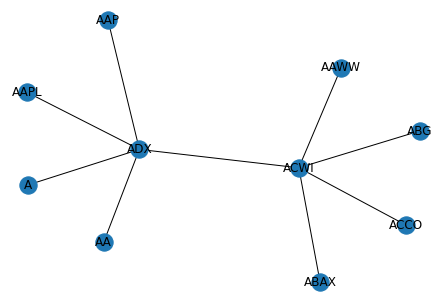

In [51]:
ref_MST1 = create_Kruskal_MST(article_corr, article_stocks)
nx.draw(ref_MST1, with_labels=True)

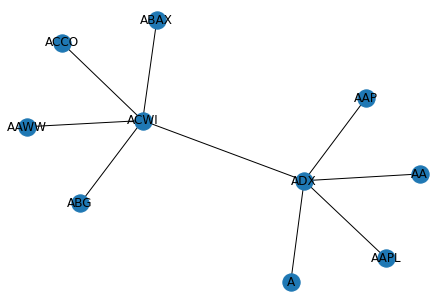

In [52]:
ref_MST2 = create_Prima_MST(article_corr, article_stocks)
nx.draw(ref_MST2, with_labels=True)

#### Генерация случайных последовательностей из нормального распределния с данной матрицей корреляции и нулевым вектором математетического ожидания, построение MST по новым СВ и сравнение его с истиным MST

##### Сравниваем истиное MST с новым MST, полученными при разных кол-вах наблюдений

In [0]:
# for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
#   print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST1, article_corr, observ, article_stocks)))

Значения из статьи: 0, 0, 0.005, 0.075, 0.258, 0.545, 0.647.     
Значит генерируем новые последовательность СВ и строим МСТ правильно (+ МСТ построенные по двум разным алгоритмам совпадают, так как ниразу не выпала -1)

### То же самое, но для матрицы корреляции, полученной из выкачанных с yahoo данных 

##### Получаем доходности 9 акций

In [54]:
returns = []
for stock in data['Close']:
  returns.append(get_returns(data['Close'][stock]))
print(len(returns))
len(returns[0])

9


252

##### Получаем матрицу корреляции этих доходностей

In [55]:
ref_corr = np.corrcoef(returns)
ref_corr

array([[1.        , 0.75469845, 0.48316114, 0.48070892, 0.66463948,
        0.62522857, 0.62078544, 0.78750364, 0.78343383],
       [0.75469845, 1.        , 0.45575762, 0.60256718, 0.67953151,
        0.62264727, 0.67435238, 0.86658063, 0.86108024],
       [0.48316114, 0.45575762, 1.        , 0.35831691, 0.38759264,
        0.41819809, 0.41857366, 0.48025615, 0.49155804],
       [0.48070892, 0.60256718, 0.35831691, 1.        , 0.45091271,
        0.5025592 , 0.46677779, 0.6488523 , 0.66867308],
       [0.66463948, 0.67953151, 0.38759264, 0.45091271, 1.        ,
        0.54078982, 0.62224391, 0.73908196, 0.72558427],
       [0.62522857, 0.62264727, 0.41819809, 0.5025592 , 0.54078982,
        1.        , 0.58184976, 0.67233712, 0.6715842 ],
       [0.62078544, 0.67435238, 0.41857366, 0.46677779, 0.62224391,
        0.58184976, 1.        , 0.721803  , 0.71850341],
       [0.78750364, 0.86658063, 0.48025615, 0.6488523 , 0.73908196,
        0.67233712, 0.721803  , 1.        , 0.941782  ],


##### Строим MST по полученной матрице корреляции

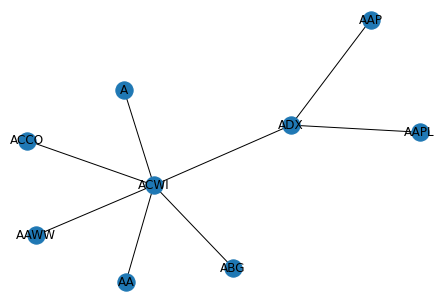

In [56]:
ref_MST = create_Kruskal_MST(ref_corr, stocks_article)
nx.draw(ref_MST, with_labels=True)

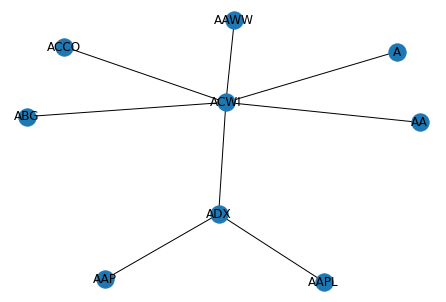

In [57]:
ref_MST = create_Prima_MST(ref_corr, stocks_article)
nx.draw(ref_MST, with_labels=True)

##### Сравниваем истиное MST с симулированными MST, полученными при разных кол-вах наблюдений

In [0]:
# for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
#   print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST, ref_corr, observ, stocks_article)))

### То же самое, но через гипотезы

##### Получаем индикаторы доходностей

In [59]:
ret_inds = get_inds_matrix(returns)
print(len(ret_inds[0]))
np.array(ret_inds).shape

252


(9, 252)

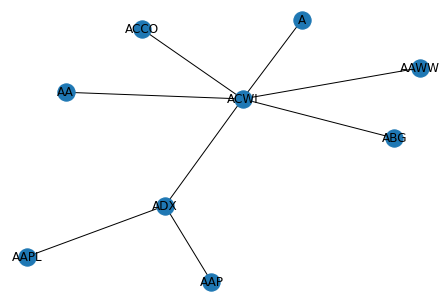

In [60]:
ref_MST = create_Prima_MST(np.corrcoef(returns), stocks_article)
nx.draw(ref_MST, with_labels=True)

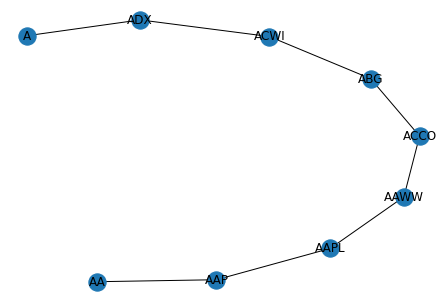

In [61]:
G = create_hypot_MST(ret_inds, stocks_article, 0.05)
nx.draw(G, with_labels=True)

True


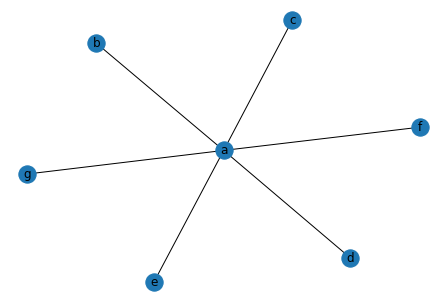

In [62]:
stcks = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
corr = [[1, 0, 0, 0, 0, 0, 0],\
        [0, 1, 0, 0, 0, 0, 0],\
        [0, 0, 1, 0, 0, 0, 0],\
        [0, 0, 0, 1, 0, 0, 0],\
        [0, 0, 0, 0, 1, 0, 0],\
        [0, 0, 0, 0, 0, 1, 0],\
        [0, 0, 0, 0, 0, 0, 1]]

ref_MST1 = create_Kruskal_MST(corr, stcks)

ref_MST2 = create_Prima_MST(corr, stcks)

print(sorted(ref_MST1.degree) == sorted(ref_MST2.degree))
nx.draw(ref_MST2, with_labels=True)


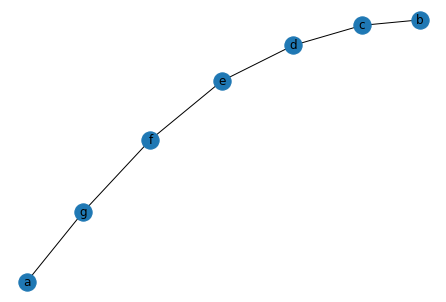

In [63]:
new_rets = get_norm_seq(corr, 100)
new_inds = get_inds_matrix(new_rets)

G = create_hypot_MST(new_inds, stcks, 0.1)
nx.draw(G, with_labels=True)

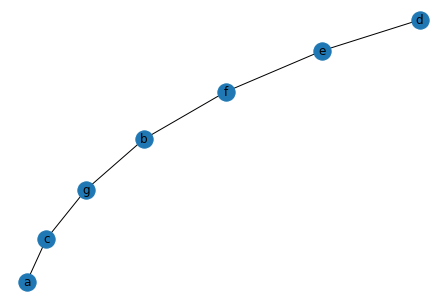

In [64]:
G = create_hypot_MST(new_inds, stcks, 0.1, kind_of_test='complex_rand')
nx.draw(G, with_labels=True)

In [0]:
def compare_procedures(ref_MST, iters=1000, alphas=[0.2, 0.15, 0.1, 0.05], seq_nums=[100]):
  for alpha in alphas:
    print('alpha = ', alpha)
    for seq_num in seq_nums:
      count_corr = 0
      count_simple = 0
      count_compl_rand = 0
      count_compl_max = 0
      for iter in range(iters):
        new_rets = get_norm_seq(corr, seq_num)
        new_inds = get_inds_matrix(new_rets)
        G_corr = create_Prima_MST(np.corrcoef(new_rets), stcks)
        G_hypoth = create_hypot_MST(new_inds, stcks, alpha)
        G_compl_rand = create_hypot_MST(new_inds, stcks, alpha, kind_of_test='complex_rand')
        G_compl_max = create_hypot_MST(new_inds, stcks, alpha, kind_of_test='complex_max')
        if sorted(ref_MST.degree) == sorted(G_corr.degree):
          count_corr += 1
        if sorted(ref_MST.degree) == sorted(G_hypoth.degree):
          count_simple += 1
        if sorted(ref_MST.degree) == sorted(G_compl_rand.degree):
          count_compl_rand += 1
        if sorted(ref_MST.degree) == sorted(G_compl_max.degree):
          count_compl_max += 1
          
      print('observations number = {} \n \
      rate of the same: \n \
      procedure of correlation: {} \n \
      simple hypothetical procedure: {} \n \
      complex (rand) hypothetical procedure: {} \n \
      complex (max) hypothetical procedure: {}'.format(seq_num, \
                                              count_corr/iters, \
                                              count_simple/iters, \
                                              count_compl_rand/iters, \
                                              count_compl_max/iters))

True


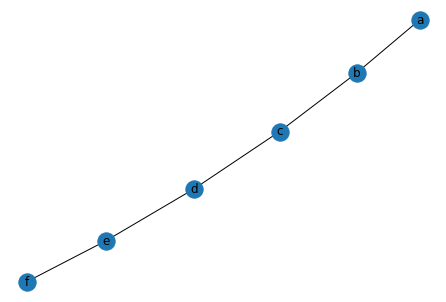

In [79]:
stcks = ['a', 'b', 'c', 'd', 'e', 'f']
corr = [[1, 0.5, 0, 0, 0, 0],\
        [0.5, 1, 0.5, 0, 0, 0],\
        [0, 0.5, 1, 0.5, 0, 0],\
        [0, 0, 0.5, 1, 0.5, 0],\
        [0, 0, 0, 0.5, 1, 0.5],\
        [0, 0, 0, 0, 0.5, 1]]

ref_MST1 = create_Kruskal_MST(corr, stcks)

ref_MST2 = create_Prima_MST(corr, stcks)

print(sorted(ref_MST1.degree) == sorted(ref_MST2.degree))
nx.draw(ref_MST2, with_labels=True)


[[ 1.          0.50309308  0.02624538  0.08503791  0.19023782  0.08211148]
 [ 0.50309308  1.          0.38872631  0.00774981  0.10412901 -0.02709614]
 [ 0.02624538  0.38872631  1.          0.53128088  0.01455224 -0.0431596 ]
 [ 0.08503791  0.00774981  0.53128088  1.          0.52045143 -0.03155902]
 [ 0.19023782  0.10412901  0.01455224  0.52045143  1.          0.55547817]
 [ 0.08211148 -0.02709614 -0.0431596  -0.03155902  0.55547817  1.        ]]


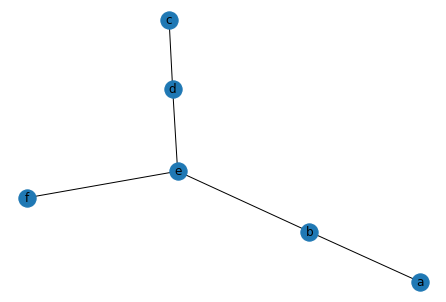

In [75]:
new_rets = get_norm_seq(corr, 100)
new_inds = get_inds_matrix(new_rets)

print(np.corrcoef(new_rets))

G = create_hypot_MST(new_inds, stcks, 0.1)
nx.draw(G, with_labels=True)

[[ 1.          0.50309308  0.02624538  0.08503791  0.19023782  0.08211148]
 [ 0.50309308  1.          0.38872631  0.00774981  0.10412901 -0.02709614]
 [ 0.02624538  0.38872631  1.          0.53128088  0.01455224 -0.0431596 ]
 [ 0.08503791  0.00774981  0.53128088  1.          0.52045143 -0.03155902]
 [ 0.19023782  0.10412901  0.01455224  0.52045143  1.          0.55547817]
 [ 0.08211148 -0.02709614 -0.0431596  -0.03155902  0.55547817  1.        ]]


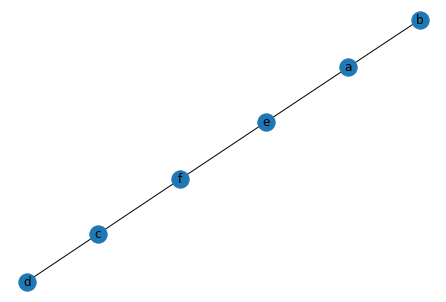

In [76]:
print(np.corrcoef(new_rets))

G = create_hypot_MST(new_inds, stcks, 0.1, kind_of_test='complex_rand')
nx.draw(G, with_labels=True)

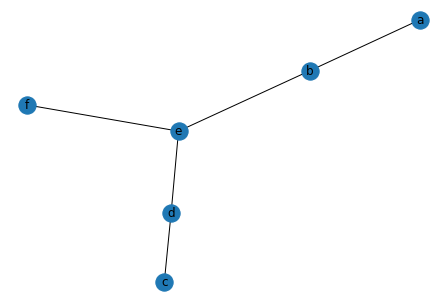

In [77]:
G = create_hypot_MST(new_inds, stcks, 0.1, kind_of_test='complex_max')
nx.draw(G, with_labels=True)

##### Compare procedures


In [80]:
compare_procedures(ref_MST1, 1000, alphas=[0.1, 0.05])

alpha =  0.1
observations number = 100 
       rate of the same: 
       procedure of correlation: 1.0 
       simple hypothetical procedure: 0.285 
       complex (rand) hypothetical procedure: 0.343 
       complex (max) hypothetical procedure: 0.226
alpha =  0.05
observations number = 100 
       rate of the same: 
       procedure of correlation: 0.998 
       simple hypothetical procedure: 0.116 
       complex (rand) hypothetical procedure: 0.171 
       complex (max) hypothetical procedure: 0.075


##### Continue

True


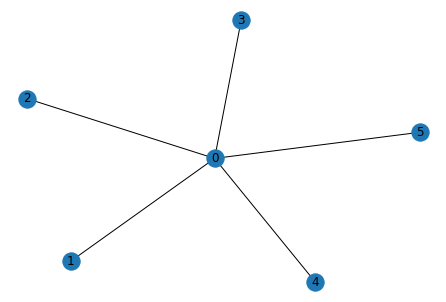

In [81]:
stcks = ['0', '1', '2', '3', '4', '5']
corr = [[1, 0.4, 0.4, 0.4, 0.4, 0.4],\
        [0.4, 1, 0, 0, 0, 0],\
        [0.4, 0, 1, 0, 0, 0],\
        [0.4, 0, 0, 1, 0, 0],\
        [0.4, 0, 0, 0, 1, 0],\
        [0.4, 0, 0, 0, 0, 1]]

ref_MST1 = create_Kruskal_MST(corr, stcks)

ref_MST2 = create_Prima_MST(corr, stcks)

print(sorted(ref_MST1.degree) == sorted(ref_MST2.degree))
nx.draw(ref_MST2, with_labels=True)


[[ 1.          0.41244269  0.36145384  0.29177373  0.41903777  0.45604584]
 [ 0.41244269  1.          0.03665534 -0.02150926 -0.06745997 -0.02678325]
 [ 0.36145384  0.03665534  1.         -0.18445846  0.05544319  0.21929171]
 [ 0.29177373 -0.02150926 -0.18445846  1.         -0.03854574 -0.1076604 ]
 [ 0.41903777 -0.06745997  0.05544319 -0.03854574  1.          0.04676406]
 [ 0.45604584 -0.02678325  0.21929171 -0.1076604   0.04676406  1.        ]]


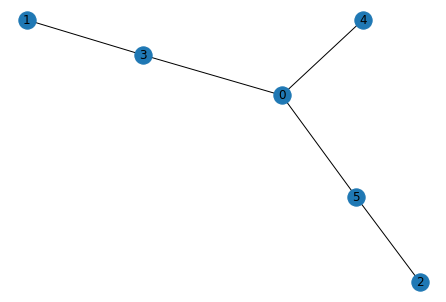

In [82]:
new_rets = get_norm_seq(corr, 100)
new_inds = get_inds_matrix(new_rets)

print(np.corrcoef(new_rets))

G = create_hypot_MST(new_inds, stcks, 0.15)
nx.draw(G, with_labels=True)

[[ 1.          0.41244269  0.36145384  0.29177373  0.41903777  0.45604584]
 [ 0.41244269  1.          0.03665534 -0.02150926 -0.06745997 -0.02678325]
 [ 0.36145384  0.03665534  1.         -0.18445846  0.05544319  0.21929171]
 [ 0.29177373 -0.02150926 -0.18445846  1.         -0.03854574 -0.1076604 ]
 [ 0.41903777 -0.06745997  0.05544319 -0.03854574  1.          0.04676406]
 [ 0.45604584 -0.02678325  0.21929171 -0.1076604   0.04676406  1.        ]]


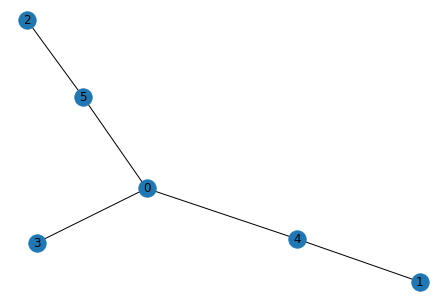

In [83]:
print(np.corrcoef(new_rets))

G = create_hypot_MST(new_inds, stcks, 0.15, kind_of_test='complex_rand')
nx.draw(G, with_labels=True)

[[ 1.          0.41244269  0.36145384  0.29177373  0.41903777  0.45604584]
 [ 0.41244269  1.          0.03665534 -0.02150926 -0.06745997 -0.02678325]
 [ 0.36145384  0.03665534  1.         -0.18445846  0.05544319  0.21929171]
 [ 0.29177373 -0.02150926 -0.18445846  1.         -0.03854574 -0.1076604 ]
 [ 0.41903777 -0.06745997  0.05544319 -0.03854574  1.          0.04676406]
 [ 0.45604584 -0.02678325  0.21929171 -0.1076604   0.04676406  1.        ]]


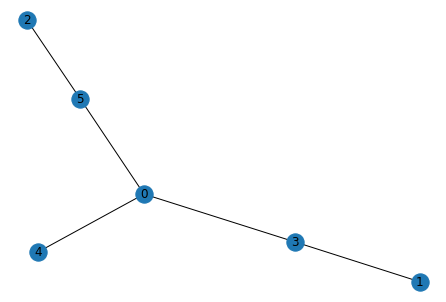

In [84]:
print(np.corrcoef(new_rets))

G = create_hypot_MST(new_inds, stcks, 0.15, kind_of_test='complex_max')
nx.draw(G, with_labels=True)


##### Compare procedures

In [85]:
compare_procedures(ref_MST1, 1000, alphas=[0.1, 0.05])

alpha =  0.1
observations number = 100 
       rate of the same: 
       procedure of correlation: 0.998 
       simple hypothetical procedure: 0.032 
       complex (rand) hypothetical procedure: 0.098 
       complex (max) hypothetical procedure: 0.014
alpha =  0.05
observations number = 100 
       rate of the same: 
       procedure of correlation: 0.999 
       simple hypothetical procedure: 0.003 
       complex (rand) hypothetical procedure: 0.048 
       complex (max) hypothetical procedure: 0.001


##### Continue

True


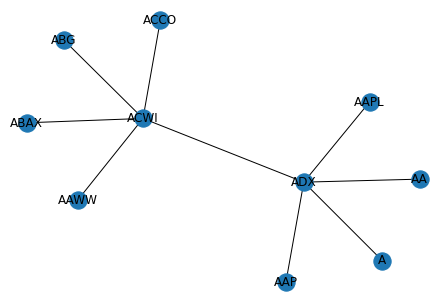

In [72]:
corr = [[1.0000, 0.7220, 0.4681, 0.4809, 0.6209, 0.5380, 0.6252, 0.6285, 0.7786, 0.7909], \
        [0.7220, 1.0000, 0.4395, 0.5979, 0.6381, 0.5725, 0.6666, 0.6266, 0.8583, 0.8640], \
        [0.4681, 0.4395, 1.0000, 0.3432, 0.3468, 0.2740, 0.4090, 0.4016, 0.4615, 0.4832], \
        [0.4809, 0.5979, 0.3432, 1.0000, 0.4518, 0.4460, 0.4635, 0.4940, 0.6447, 0.6601], \
        [0.6209, 0.6381, 0.3468, 0.4518, 1.0000, 0.5640, 0.5994, 0.5369, 0.7170, 0.7136], \
        [0.5380, 0.5725, 0.2740, 0.4460, 0.5640, 1.0000, 0.4969, 0.4775, 0.6439, 0.6242], \
        [0.6252, 0.6666, 0.4090, 0.4635, 0.5994, 0.4969, 1.0000, 0.6098, 0.7161, 0.7158], \
        [0.6285, 0.6266, 0.4016, 0.4940, 0.5369, 0.4775, 0.6098, 1.0000, 0.6805, 0.6748], \
        [0.7786, 0.8583, 0.4615, 0.6447, 0.7170, 0.6439, 0.7161, 0.6805, 1.0000, 0.9523], \
        [0.7909, 0.8640, 0.4832, 0.6601, 0.7136, 0.6242, 0.7158, 0.6748, 0.9523, 1.0000]]

stcks = ['A', 'AA', 'AAP', 'AAPL', 'AAWW', 'ABAX', 'ACCO', 'ABG', 'ACWI', 'ADX']

ref_MST1 = create_Kruskal_MST(corr, stcks)

ref_MST2 = create_Prima_MST(corr, stcks)

print(sorted(ref_MST1.degree) == sorted(ref_MST2.degree))
nx.draw(ref_MST2, with_labels=True)

In [0]:
new_rets = get_norm_seq(corr, 100)
new_inds = get_inds_matrix(new_rets)

print(np.corrcoef(new_rets))

G = create_hypot_MST(new_inds, stcks, 0.15)
nx.draw(G, with_labels=True)

In [0]:
print(np.corrcoef(new_rets))

G = create_hypot_MST(new_inds, stcks, 0.15, kind_of_test='complex_rand')
nx.draw(G, with_labels=True)

In [0]:
print(np.corrcoef(new_rets))

G = create_hypot_MST(new_inds, stcks, 0.15, kind_of_test='complex_max')
nx.draw(G, with_labels=True)

###### Compare procedures

In [73]:
compare_procedures(ref_MST1, 1000, alphas=[0.1, 0.05])

alpha =  0.1
observations number = 100 
       rate of the same: 
       procedure of correlation: 0.068 
       simple hypothetical procedure: 0.0 
       complex (rand) hypothetical procedure: 0.0 
       complex (max) hypothetical procedure: 0.0
alpha =  0.05
observations number = 100 
       rate of the same: 
       procedure of correlation: 0.066 
       simple hypothetical procedure: 0.0 
       complex (rand) hypothetical procedure: 0.0 
       complex (max) hypothetical procedure: 0.0


##### Continue

In [19]:
X = [1, 2, 3]
Y = [5, 3, 8]

np.corrcoef(X, Y)

array([[1.        , 0.59603956],
       [0.59603956, 1.        ]])

In [22]:
np.sqrt(27)/np.sqrt(76)

0.5960395606792697